#Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# Load The dataset

In [11]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [12]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


# Checking The Data

In [13]:
df.shape

(299, 13)

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df.isnull().sum()

,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


# Co-realation

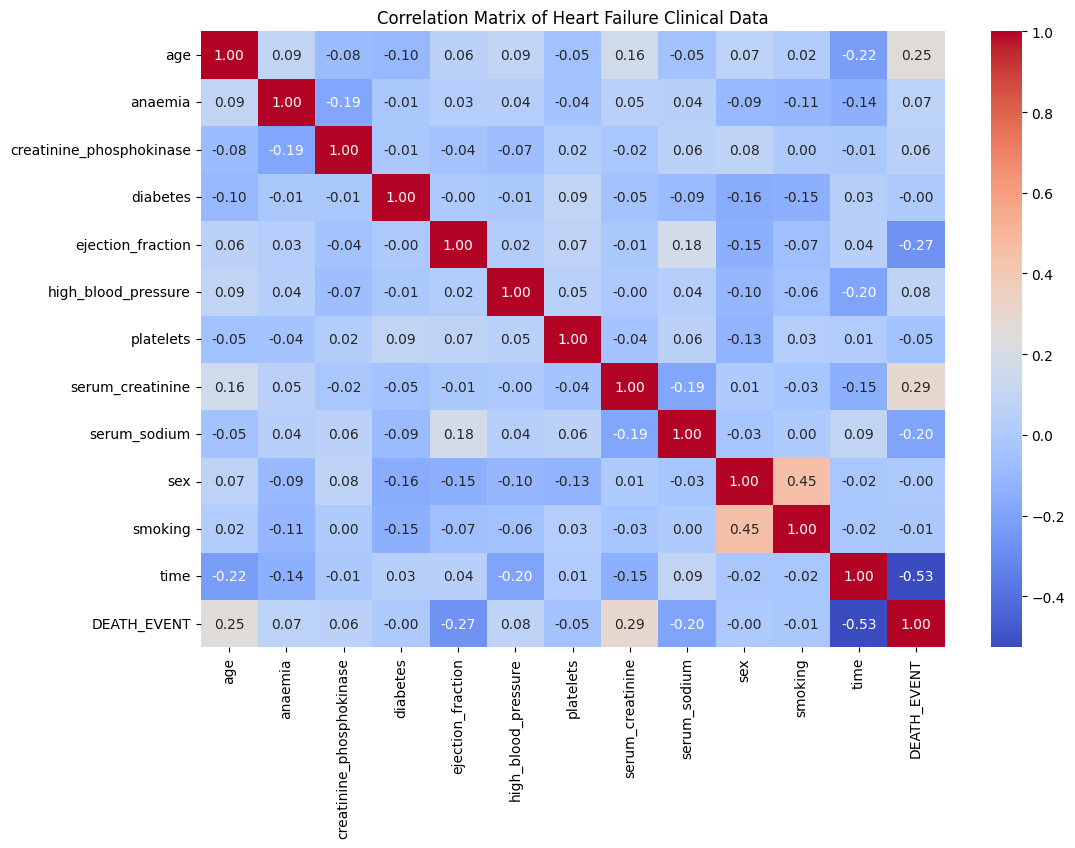

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Heart Failure Clinical Data')
plt.show()

#Targets

In [17]:
target = "DEATH_EVENT"
binary_cols = ["anaemia","diabetes","high_blood_pressure","sex","smoking"]
num_cols = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"]

In [18]:
print("Class ratio:\n", df[target].value_counts(normalize=True))

Class ratio:
 DEATH_EVENT
0    0.67893
1    0.32107
Name: proportion, dtype: float64


#Train/Validation split

In [19]:
x = df.drop(columns=[target]).copy()
y = df[target].astype(np.int64).values

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
     x, y, test_size=0.2, random_state=42, stratify=y        # stratify=y it helps to maintain the imbalanced dataset
)

#  Standardize

In [21]:
scaler = StandardScaler()
x_train_num = scaler.fit_transform(x_train[num_cols].values.astype(np.float32))
x_test_num = scaler.transform(x_test[num_cols].values.astype(np.float32))

In [22]:
def combine(cont_array, df_part):
    bins = df_part[binary_cols].values.astype(np.float32)   # keep 0/1 as floats
    return np.concatenate([cont_array, bins], axis=1)       # final feature matrix

# Final numpy arrays ready for PyTorch
Xtr = combine(x_train_num, x_train)
Xva = combine(x_test_num, x_test)

# Input dimension = number of features (continuous + binary)
in_dim = Xtr.shape[1]
print("Train shape:", Xtr.shape, "Validation shape:", Xva.shape, "Input dim:", in_dim)

Train shape: (239, 12) Validation shape: (60, 12) Input dim: 12


# Wrap data for PyTorch


In [23]:
import torch
from torch.utils.data import Dataset, DataLoader

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [31]:
from torch.utils.data import Dataset, DataLoader
import torch
class HFDS(Dataset):

  def __init__(self,x,y):
    self.x= torch.tensor(x.values,dtype=torch.float32)
    self.y= torch.tensor(y,dtype=torch.float32)

  def __len__(self):
    return len(self.x)

  def __getitem__(self,i):
    return self.x[i],self.y[i]

#building the dataset objects
train_ds = HFDS(x_train,y_train)
test_ds = HFDS(x_test,y_test)

train_ds = DataLoader(train_ds, batch_size=64, shuffle=True)
test_ds = DataLoader(test_ds, batch_size=256, shuffle=False)

# ANN Module

In [32]:
import torch.nn as nn
import torch.optim as optim

In [37]:
import torch.nn as nn
import torch.optim as optim

# A simple 2-hidden-layer MLP (good baseline for tabular data)
class MLP(nn.Module):
    def __init__(self, in_dim, h1=128, h2=64, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),  # input → first hidden layer
            nn.ReLU(),              # activation
            nn.Dropout(p),          # regularization
            nn.Linear(h1, h2),      # first hidden → second hidden
            nn.ReLU(),              # activation
            nn.Dropout(p),          # regularization
            nn.Linear(h2, 1)        # final output logit (before sigmoid)
        )
    def forward(self, x):
        return self.net(x)          # pass input through the layers

# Create the model and send to device (CPU/GPU)
model = MLP(in_dim).to(device)

# (Optional but helpful) handle class imbalance:
# pos_weight = (#negatives / #positives) computed on TRAIN labels
pos = float((y_train == 1).sum())
neg = float((y_train == 0).sum())
pos_weight = torch.tensor([neg / max(pos, 1.0)], device=device)

# Binary cross-entropy with logits (includes sigmoid inside)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Adam optimizer: adjusts weights using gradients
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Reduce learning rate if validation loss stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

# Train & Validate

In [41]:
# One full pass over a DataLoader (either training or validation)
def epoch_run(model, loader, train=True):
    model.train() if train else model.eval()          # enable/disable dropout etc.
    total_loss, total, correct = 0.0, 0, 0            # counters
    all_logits, all_y = [], []                        # store outputs/labels (optional)

    for xb, yb in loader:                             # loop over mini-batches
        xb, yb = xb.to(device), yb.to(device)         # move batch to CPU/GPU

        if train:
            optimizer.zero_grad()                     # clear old gradients

        logits = model(xb)                            # forward pass → raw scores
        loss   = criterion(logits, yb.unsqueeze(1))  # compute loss with unsqueezed target

        if train:
            loss.backward()                           # backpropagate gradients
            optimizer.step()                          # update model weights

        total_loss += loss.item() * xb.size(0)        # accumulate batch loss

        with torch.no_grad():                         # metrics don't need gradients
            probs = torch.sigmoid(logits)             # convert logits → probabilities
            preds = (probs >= 0.5).float()            # 0/1 prediction via threshold
            correct += (preds == yb).sum().item()     # count correct
            total   += xb.size(0)                     # count examples
            all_logits.append(logits.detach().cpu())  # save for later analysis
            all_y.append(yb.detach().cpu())           # save true labels

    avg_loss = total_loss / total                     # average loss over all samples
    acc = correct / total                             # accuracy
    return avg_loss, acc, torch.cat(all_logits).view(-1), torch.cat(all_y).view(-1)

# Train for N epochs, keep the best validation weights
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
EPOCHS, best_val, best_state = 30, float("inf"), None         # 30 is a good quick start

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _   = epoch_run(model, train_ds, train=True)    # training pass
    va_loss, va_acc, _, _   = epoch_run(model, test_ds,   train=False)   # validation pass
    scheduler.step(va_loss)                                                 # maybe lower LR

    # log history for plotting later
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    # save the best model by validation loss
    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    # print progress every few epochs (and at the first)
    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:02d}/{EPOCHS} | "
              f"train_loss={tr_loss:.4f}, train_acc={tr_acc:.3f} | "
              f"val_loss={va_loss:.4f}, val_acc={va_acc:.3f}")

# Load best weights (lowest validation loss seen)
if best_state is not None:
    model.load_state_dict(best_state)

Epoch 01/30 | train_loss=4370.9755, train_acc=30.636 | val_loss=1699.2010, val_acc=19.000
Epoch 05/30 | train_loss=2337.8916, train_acc=34.109 | val_loss=1156.5624, val_acc=41.000
Epoch 10/30 | train_loss=1409.3217, train_acc=28.766 | val_loss=683.0272, val_acc=19.000
Epoch 15/30 | train_loss=714.8702, train_acc=31.180 | val_loss=372.0197, val_acc=41.000
Epoch 20/30 | train_loss=441.4303, train_acc=31.795 | val_loss=108.3119, val_acc=41.000
Epoch 25/30 | train_loss=303.0209, train_acc=28.607 | val_loss=55.0098, val_acc=19.000
Epoch 30/30 | train_loss=330.6765, train_acc=30.389 | val_loss=29.3080, val_acc=19.000


# Curves


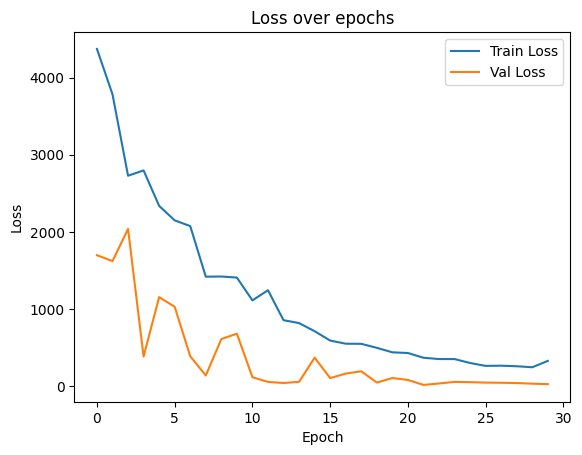

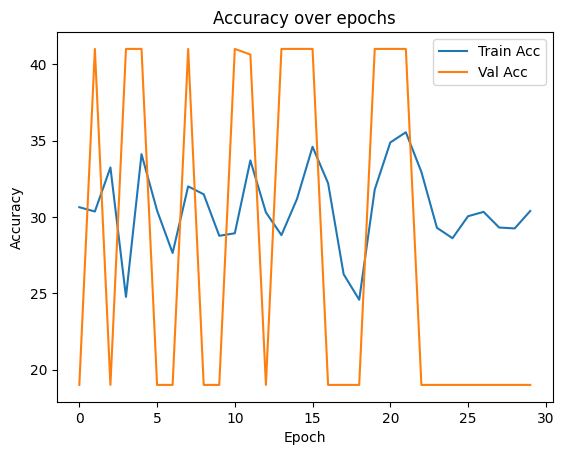

Confusion matrix:
 [[41  0]
 [19  0]]

Classification report:
               precision    recall  f1-score   support

           0      0.683     1.000     0.812        41
           1      0.000     0.000     0.000        19

    accuracy                          0.683        60
   macro avg      0.342     0.500     0.406        60
weighted avg      0.467     0.683     0.555        60



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


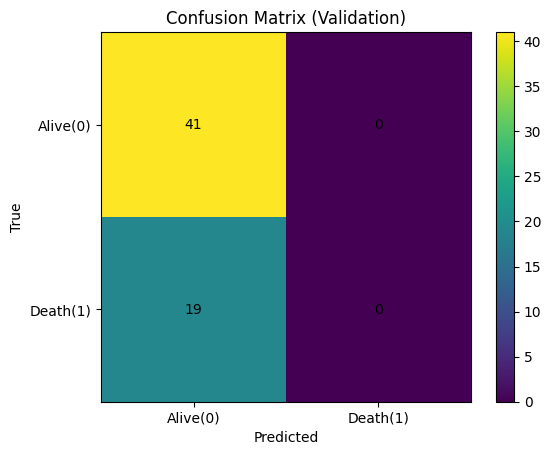

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Plot training vs validation loss
plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training vs validation accuracy
plt.figure()
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Final predictions on validation set
model.eval()
_, _, logits, y_true = epoch_run(model, test_ds, train=False)
probs = torch.sigmoid(logits).numpy()        # convert logits → probabilities
preds = (probs >= 0.5).astype(int)           # threshold at 0.5 → class 0/1
y_true = y_true.numpy().astype(int)          # convert to NumPy ints

# Confusion matrix + classification report
cm = confusion_matrix(y_true, preds)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_true, preds, digits=3))

# (Optional) Simple visual for confusion matrix
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Alive(0)","Death(1)"])
plt.yticks(tick_marks, ["Alive(0)","Death(1)"])
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()

# New Prediction


In [45]:
# The model expects features in this specific order:
all_cols_order = num_cols + binary_cols

def predict_rows(df_rows):
    """
    df_rows: a pandas DataFrame with the SAME columns as training (except the target).
    Returns: probabilities (between 0 and 1) that DEATH_EVENT = 1.
    """
    # Reorder columns to match training order
    df_rows = df_rows[all_cols_order].copy()

    # Scale continuous columns using the TRAIN-fitted scaler
    Xc = scaler.transform(df_rows[num_cols].values.astype(np.float32))

    # Binary columns remain as-is (but cast to float32)
    Xb = df_rows[binary_cols].values.astype(np.float32)

    # Combine into final feature matrix
    X_ = np.concatenate([Xc, Xb], axis=1)

    # Predict with the trained model
    with torch.no_grad():
        logits = model(torch.tensor(X_, dtype=torch.float32).to(device))
        probs = torch.sigmoid(logits).cpu().numpy().ravel()  # 1D array of probabilities
    return probs

# Demo: predict for first 3 validation rows
example_probs = predict_rows(x_test.iloc[:3])
example_probs

array([0.50684875, 0.5045759 , 0.50484645], dtype=float32)